# Exploratory Data Analysis

## Table of contents
* [Introduction](#chapter1)
* [Time Series patters](#chapter2)
    * [Trend](#chapter2_1)
    * [Seasonality](#chapter2_2)
    * [Autocorrelation](#chapter2_3)
* [Naive Decomposition in Trend, Sesonal and Residuals](#chapter3)
* [Stationarity](#chapter4)
* [Processing 2020](#2020)
* [Conclusions](#chapter5)

# Introduction<a class="anchor" id="chapter1"></a>

This notebook explains the time series provided. First, an analysis of the series is carried out, exploring the traditional patterns of a time series. Subsequently, a basic decomposition into seasonal pattern and trend is analysed to set a baseline before training the models. Then, statistical tests are carried out to support the graphical conclusions. Finally, procssing of year 2020 is conducted in order not to carry over the effects of poor data quality into the 2021 forecasts (see conclusions).

**Note:** In this analysis the whole time series provided has been used, exploring also the effect of taking some subsets of the data.

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# filter warnings
import warnings

warnings.filterwarnings("ignore")

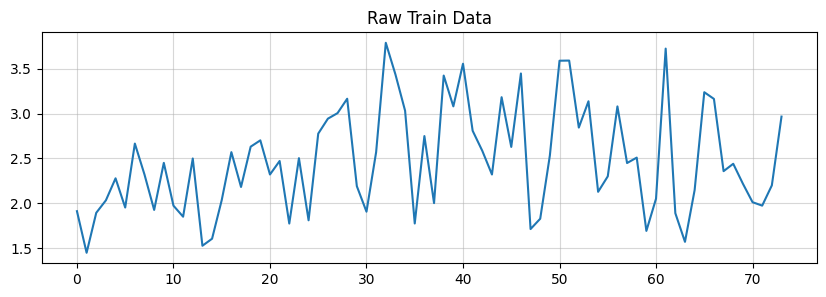

In [14]:
# Read train data
ts = pd.read_csv(
    "../data/train.csv",  # data path
    index_col=[0],  # index column
    parse_dates=[0],  # parse date column
    date_format="%d.%m.%y",  # date format
)

# Get training data
train_ts = ts.dropna()

# Quick look at the data
# print(train_ts[:13]) # We expect monthly measurements
# print(train_ts.describe()) # Check max, min, count...

# print()
# print(f'First date: {train_ts.iloc[0].name}')
# print(f'Last date: {train_ts.iloc[-1].name}')

# Assert time series dates consistency by checking all dates are monthly and recorded properly (this includes missing dates if any)
train_ts = train_ts.asfreq("MS").fillna(
    0
)  # if there are missing dates, they will be filled with 0


# Visualize the data
plt.figure(figsize=(10, 3))
plt.plot(train_ts.values)

# plt.plot(train_ts.rolling(24, center=True).mean(), marker='o')

plt.title("Raw Train Data")
plt.grid(alpha=0.5)

# Time Series patterns<a class="anchor" id="chapter2"></a>
Exploration of traditional time series patterns:
- Trend: here defined as a long-term evolution of the time series. It should represent the overall increase or decrease of the series without considering noise or other patterns.
- Seasonal patterns: pattern that repeats every X periods. A seasonal pattern of period 12 (repetition of the annual structure) could be expected.
- Cycles: pattern that repeats every X periods but not necessarily with the same amplitude. It could be a cycle of 2 years for example. Usually related to economic or business cycles.

## Trend<a class="anchor" id="chapter2_1"></a>

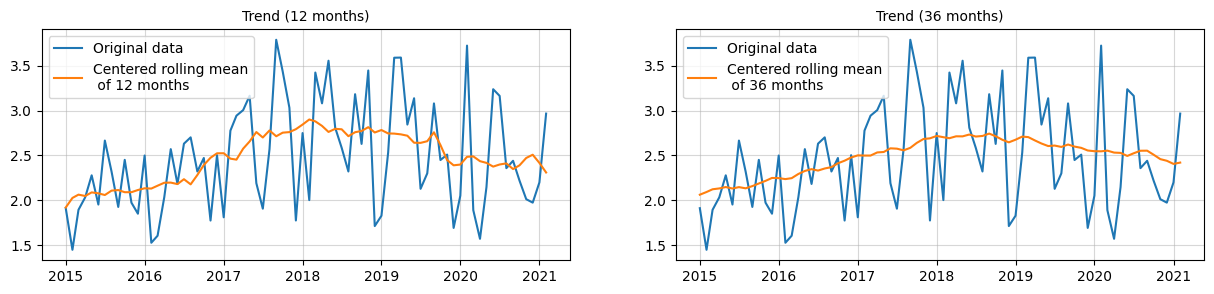

In [15]:
# TREND

# Smooth series by rolling mean of 12 months (a year) to remove seasonality and explore long term trends (with this window size, trend is still fuzzy)
# Expand window size to 36 to get a smoother and consistent trend 
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
for i, window_size in enumerate([12, 36]):
    axes[i].plot(train_ts, label="Original data")
    axes[i].plot(train_ts.rolling(window_size, center=True, min_periods=1).mean(), label=f"Centered rolling mean\n of {window_size} months")
    axes[i].grid(alpha=0.5)
    axes[i].legend()
    axes[i].set_title(f"Trend ({window_size} months)", fontsize=10)

plt.show()

- Data contains a **trend** (looks like a cubic curve with perhaps change point around 2018)
- Time series is **not stationary**: the mean and variance of the series change over time (this will be addressed before the modeling because some models impose stationarity as a hypothesis)

## Seasonality<a class="anchor" id="chapter2_2"></a>

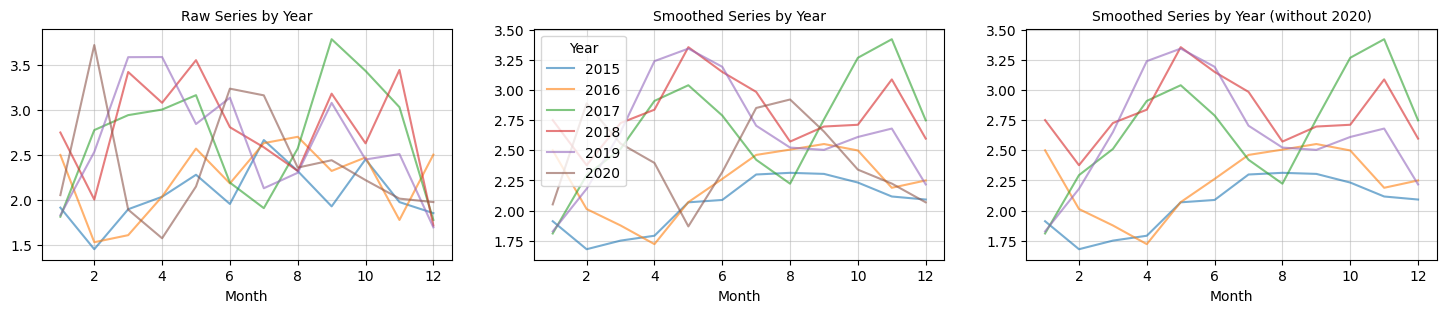

In [16]:
# SEASONALITY

season_df = train_ts.copy()

# Add date related features 
season_df["Year"] = season_df.index.year
season_df["Month"] = season_df.index.month

# Filter out 2021 since this year is not complete
season_df = season_df[season_df.index.year < 2021]

# Pivot table to get a year in each column and month in each row
season_pivot = pd.pivot_table(season_df, values="y", index="Month", columns="Year")

# Plot raw and rolling year data
fig, axes = plt.subplots(1, 3, figsize=(18, 3))
season_pivot.plot(ax=axes[0], alpha=0.6)
axes[0].set_title("Raw Series by Year", fontsize=10)
axes[0].legend().remove()

season_pivot.rolling(3, min_periods=1).mean().plot(ax=axes[1], alpha=0.6)
axes[1].set_title("Smoothed Series by Year", fontsize=10)

season_pivot.drop([2020], axis=1).rolling(3, min_periods=1).mean().plot(ax=axes[2], alpha=0.6)
axes[2].set_title("Smoothed Series by Year (without 2020)", fontsize=10)
axes[2].legend().remove()

for ax in axes:
    ax.grid(alpha=0.5)

plt.show()

- A 12-month period is explored, i.e. annual repeat.
- Patterns in the first plot of raw data grouped by year can not be seen, so a smoothing of 3 months is applied to the data to better visualize the patterns.
- The second and third plots show the smoothed data. 
- A **common pattern** can be intuited **in [2015 and 2016]**, and on the other hand, **another different pattern** in **[2017, 2018 and 2019]** -> **change of seasonality pattern** (why?).
- 2020 series has a different pattern, probably due to the COVID-19 pandemic. This is a common issue in many time series during 2020, therefore a processing of the data to remove this effect is needed.
- The **trend** is also appreciated in these plots, since the underlying **mean** of each year is **varying**.

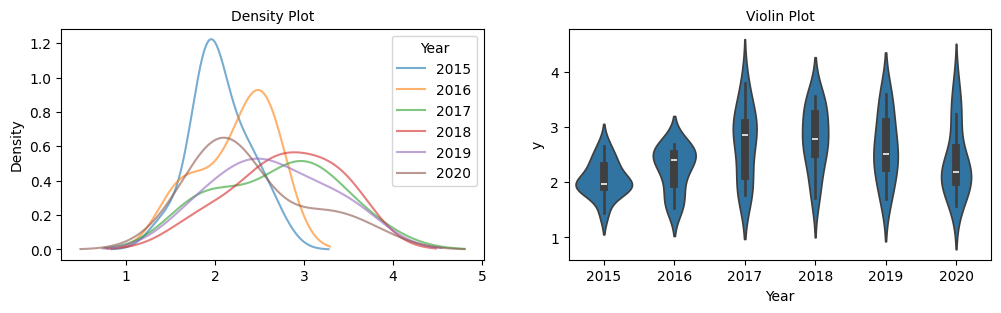

In [17]:
# DISTRIBUTION

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
season_pivot.plot(kind="kde", ax=axes[0], alpha=0.6)
axes[0].set_title("Density Plot", fontsize= 10)

sns.violinplot(data=season_df, x="Year", y="y",  ax=axes[1])
axes[1].set_title("Violin Plot", fontsize = 10)

plt.show()

- In time series, time dependence is really important. Here it has been removed to study the distribution of the series by year.
- Variability increases from the first two years onwards with the mean, as the density plot shows. The variance is therefore non constant over time, so the series is **not variance-stationary** either. Since variance increase with the mean, this is a **heteroscedastic** series.
- All distributions are skewed according to the effect of the trend.
- The distributions for 2017, 2018 and 2019 are the most similar to each other. This (together with the study of the trend and seasonal patterns) will mean that 2018 is likely to be relatively well predicted with respect to 2017, and 2019 with respect to 2018 (and 2017). Using only the past of the series, **2020 will be very difficult (or impossible) to predict**, as it follows completely different patterns and distribution. 

## Autocorrelation<a class="anchor" id="chapter2_3"></a>

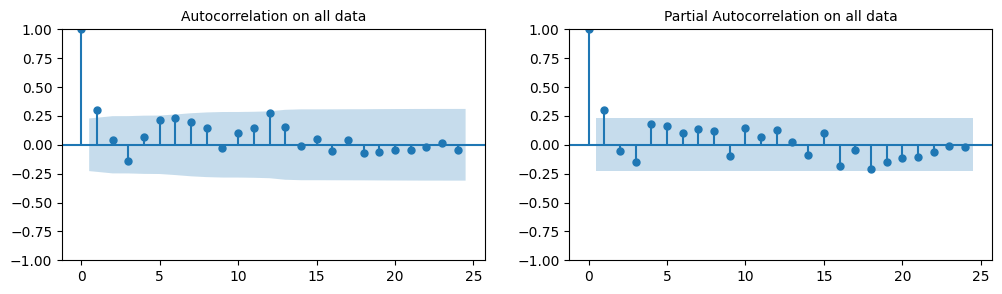

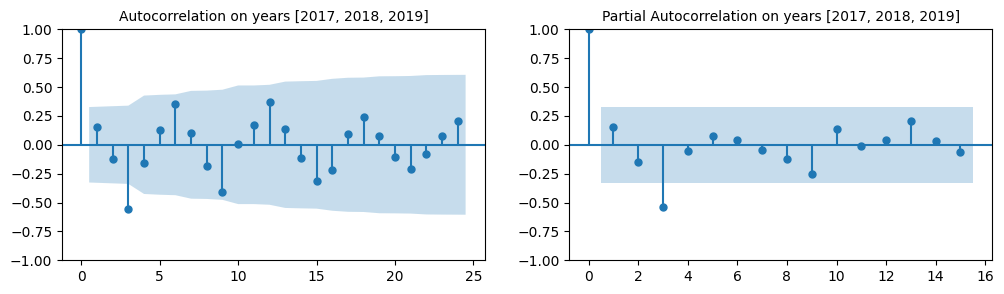

In [18]:
# AUTOCORRELATION

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
plot_acf(train_ts, lags=24, ax=axes[0])
axes[0].set_title("Autocorrelation on all data", fontsize=10)

plot_pacf(train_ts, lags=24, ax=axes[1])
axes[1].set_title("Partial Autocorrelation on all data", fontsize=10)
plt.show()

# Autocorrelation plot for years [2017, 2018, 2019]
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

plot_acf(train_ts[train_ts.index.year.isin([2017, 2018, 2019])], lags=24, ax=axes[0])
axes[0].set_title("Autocorrelation on years [2017, 2018, 2019]", fontsize=10)

plot_pacf(train_ts[train_ts.index.year.isin([2017, 2018, 2019])], lags=15, ax=axes[1])
axes[1].set_title("Partial Autocorrelation on years [2017, 2018, 2019]", fontsize=10)
plt.show()

All data:
- Autocorrelation function plot shows that data is not random: there is a significant lag 1 followed by a seasonal pattern of lag 12. This is consistent with the previous plots.
- Partial autocorrelation plot shows a significant lag 1, suggesting an AR(1). 

Filtered years 2017, 2018, 2019:
- There is a clear seasonal pattern in the ACF plot (sinusoidal curve). 

# Naive Decomposition in Trend, Seasonal and Residuals<a class="anchor" id="chapter3"></a>

Once the trend, seasonal part and distribution of the data have been studied, an attempt is made to decompose the series into trend and seasonal part (and residual). 

The objective here is to obtain a very basic, but necessary baseline. 

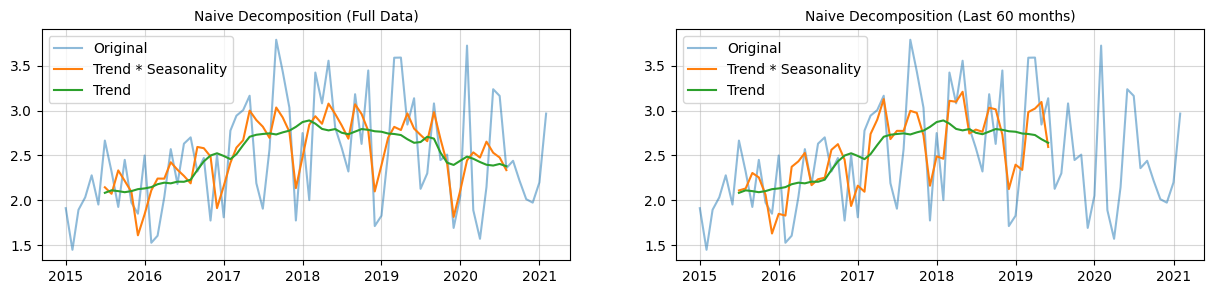

In [19]:
# NAIVE DECOMPOSITION IN TREND, SEASONALITY AND RESIDUALS

from statsmodels.tsa.seasonal import seasonal_decompose

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

for i, train_size in enumerate([len(train_ts), 60]):
    res = seasonal_decompose(train_ts[:train_size].values.ravel(), period=12, model='multiplicative')

    axes[i].plot(train_ts, alpha=0.5, label='Original')
    axes[i].plot(train_ts[:train_size].index, (res.trend) * (res.seasonal), label='Trend * Seasonality'	)
    axes[i].plot(train_ts[:train_size].index, res.trend, label='Trend')
    axes[i].grid(alpha=0.5)
    axes[i].legend()

axes[0].set_title("Naive Decomposition (Full Data)", fontsize=10)
axes[1].set_title("Naive Decomposition (Last 60 months)", fontsize=10)
plt.show()

- With this decomposition it can be seen that depending on the training data, the seasonal pattern changes. This is because seasonal pattern is not very well defined as seen above. Especially, when considering all training data, the year 2020 skews this seasonal pattern. 
- Trend remains the same. 

# Stationarity <a class="anchor" id="chapter4"></a>
It has been shown graphically that the series is not stationary: the mean and variance are not constant over time. However, statistical tests will be run to prove it. 

In [20]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, maxlag=24)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)



def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

# ADF and KPSS tests
adf_test(train_ts.values)
print()
kpss_test(train_ts.values)

Results of Dickey-Fuller Test:
Test Statistic                 -5.286557
p-value                         0.000006
#Lags Used                      2.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64

Results of KPSS Test:
Test Statistic           0.521951
p-value                  0.036723
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


- Time series is stationary according to Dickey-Fuller Test (p-value < 0.05 = significance level).
- Time series is **not** trend-stationary according to KPSS Test (p-value < 0.05 = significance level).
- Since ADF indicates stationarity and KPSS not, the series has to be detrended. A **difference of first order** will be applied to test stationarity again.

# 2020 Processing<a class="anchor" id="2020"></a>
- The year 2020 needs to be addressed so as not to carry over possible effects of the pandemic into the 2021 predictions. 
- One option would be to remove it from the training set, but it could be that COVID-19 has not affected this year even though it seems to have. 
- The average of 2019 and 2020 will be used to define a new 2020.

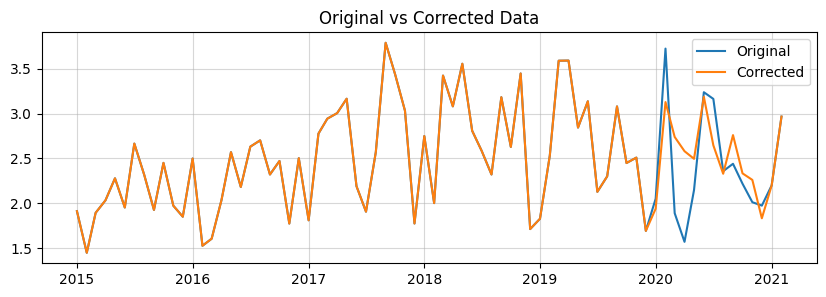

In [21]:
# 2020 PROCESSING

# Define 2020 as (2019+2020)/2
processed_train_ts = train_ts.copy()

# Get 2020 and 2019 data
train_ts_2020 = processed_train_ts[processed_train_ts.index.year==2020]
train_ts_2019 = processed_train_ts[processed_train_ts.index.year==2019]

# Calculate mean of 2020 and 2019
mean_2020_2019 = pd.DataFrame((train_ts_2020.values.ravel() + train_ts_2019.values.ravel()) / 2, index=train_ts_2020.index, columns=['y'])

# Delete from processed_train_ts 2020 data
processed_train_ts = processed_train_ts.drop(train_ts_2020.index)

# Union processed_train_ts with mean_2020_2019
processed_train_ts = pd.concat([processed_train_ts, mean_2020_2019]).sort_index()

# Plot original vs corrected data
plt.figure(figsize=(10, 3))
plt.plot(train_ts, label='Original')
plt.plot(processed_train_ts, label='Corrected')
plt.title('Original vs Corrected Data')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [22]:
# export the processed data
processed_train_ts.to_csv('../data/processed_train.csv')

# Conclusions<a class="anchor" id="chapter5"></a>
The original data series have been analysed here, drawing the following important conclusions:
1. Data contains a **trend** (looks like a cubic curve with perhaps change point around 2018)
2. There is **no stable seasonal pattern** that is repeated **every year**. There is a **seasonal pattern in 2017, 2018 and 2019**. 
3. The distribution of the data varies substantially between years and **only the distributions for 2017, 2018 and 2019 appear similar**.
4. Moreover, the variance increases with the mean -**heteroscedasticity**- (it is advisable to study the effect of some transformation to stabilise the variance, e.g. taking the log of the series). This together with the trend (and conclusions of ADF and KPSS tests) makes the series **non-stationary**. A differentiation or other detrended method has to be applied to the series. 
5. The year **2020 follows a different distribution** to the rest of the series and does not repeat the seasonal patterns of previous years. It is not known whether the effect of COVID-19 could have affected the values of this series, but as a precaution this year will be treated carefully.
6. The series has been decomposed into seasonal part, trend and noise with a **naive** method. This line will be followed to set a **baseline**.
7. COVID-19 potential issues have been removed by processing the series of 2020. 